In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
from model import *
from utils import *

In [2]:
parser = argparse.ArgumentParser('Proyecto_8091', add_help=False)
parser.add_argument('--data_folder', default='./data', type=str, help='Folder path to dataset')
parser.add_argument('--magnetometry_folder', default='Datos_Magnetometria_Anomalia_Magnetica_de_Campo_Total', type=str, help='Folder path to magnetometry data')
args = parser.parse_args(args=[])

# load data
magnetometry_path = os.path.join(args.data_folder, args.magnetometry_folder, "Puntos_Grilla_Anomalia_Magnetica_de_Campo_Total_SGC.xlsx")

df_magnetometry = pd.read_excel(magnetometry_path)

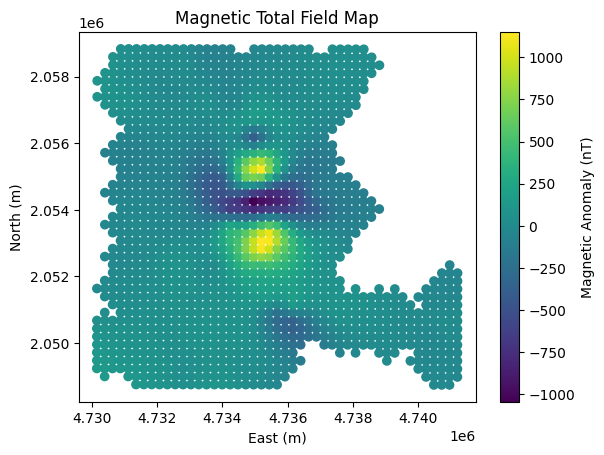

In [3]:
# Scatter plot of magnetic anomaly
plt.scatter(df_magnetometry["Este"], df_magnetometry["Norte"], c=df_magnetometry["Anomalia_Magnetica_Campo_Total"], cmap="viridis")
plt.colorbar(label="Magnetic Anomaly (nT)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Magnetic Total Field Map")
plt.show()

In [4]:
# Coordinates and values
x_magn = df_magnetometry["Este"].values
y_magn = df_magnetometry["Norte"].values
z_magn = df_magnetometry["Anomalia_Magnetica_Campo_Total"].values

grid_x_magn1, grid_y_magn1 = np.mgrid[x_magn.min():x_magn.max():200j, y_magn.min():y_magn.max():200j]

In [5]:
# numpy matrix
coords_magn = np.stack([x_magn, y_magn], axis=1).astype(np.float32)   # [M, 2]
targets_magn = z_magn.astype(np.float32).reshape(-1, 1)               # [M, 1]

coords_magn_min = np.stack([np.min(x_magn), np.min(y_magn)], axis=0).astype(np.float32) 
coords_magn_max = np.stack([np.max(x_magn), np.max(y_magn)], axis=0).astype(np.float32)

targets_magn_max = np.max(targets_magn)   
targets_magn_min = np.min(targets_magn)   


Xm_n = (coords_magn[:,0]-coords_magn_min[0])/(coords_magn_max[0]-coords_magn_min[0])
Ym_n = (coords_magn[:,1]-coords_magn_min[1])/(coords_magn_max[1]-coords_magn_min[1])


coords_magn_norm = np.stack([Xm_n, Ym_n], axis=1).astype(np.float32)

# DataLoaders
ds_magn = TensorDataset(torch.from_numpy(coords_magn_norm), torch.from_numpy(targets_magn))

dl_magn = DataLoader(ds_magn, batch_size=256, shuffle=True)

In [6]:
#Split dataloader
batch_size = 256
train_magn, val_magn = train_val_split(ds_magn, val_ratio=0.2)

dl_magn_train = DataLoader(train_magn, batch_size=batch_size, shuffle=True, num_workers=0)
dl_magn_val   = DataLoader(val_magn,   batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
###### Training
activation = "wire"
input_transform = True

if activation == "wire":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=5, hidden_units=512,
        activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
    )

if activation == "sine":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=5, hidden_units=512,
        activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
    )

epochs = 5000

lr = 1e-4
max_lr = 2e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_magn),
    epochs=epochs
)

loss = []

In [20]:
for epoch in range(epochs):
    for batch_magn in dl_magn_train:
        optimizer.zero_grad()
        coords_magn, target_magn = batch_magn
        pred_magn = model(coords_magn)
        pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

        loss = criterion(pred_magn_denorm,target_magn)
        loss.backward()
        optimizer.step()
        scheduler.step()

    if (epoch + 1) % 100 == 0:
        torch.save(model.state_dict(), f'checkpoints/magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth')

    print("Epoch: ", epoch, " Loss: ", loss.item())      

Epoch:  0  Loss:  3950501.25
Epoch:  1  Loss:  653288.5
Epoch:  2  Loss:  150346.953125
Epoch:  3  Loss:  919937.0
Epoch:  4  Loss:  1279166.75
Epoch:  5  Loss:  942861.9375
Epoch:  6  Loss:  411732.5625
Epoch:  7  Loss:  117875.671875
Epoch:  8  Loss:  87092.375
Epoch:  9  Loss:  272627.53125
Epoch:  10  Loss:  261867.03125
Epoch:  11  Loss:  238102.03125
Epoch:  12  Loss:  138722.296875
Epoch:  13  Loss:  65723.28125
Epoch:  14  Loss:  79863.9375
Epoch:  15  Loss:  87994.0703125
Epoch:  16  Loss:  141576.8125
Epoch:  17  Loss:  103713.96875
Epoch:  18  Loss:  73136.0703125
Epoch:  19  Loss:  87266.8125
Epoch:  20  Loss:  72686.3828125
Epoch:  21  Loss:  66734.2265625
Epoch:  22  Loss:  63844.40625
Epoch:  23  Loss:  69633.8046875
Epoch:  24  Loss:  84143.84375
Epoch:  25  Loss:  63611.890625
Epoch:  26  Loss:  89340.109375
Epoch:  27  Loss:  91712.7578125
Epoch:  28  Loss:  57261.51953125
Epoch:  29  Loss:  57166.13671875
Epoch:  30  Loss:  44027.11328125
Epoch:  31  Loss:  82058.648

In [ ]:
if activation == "wire":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=5, hidden_units=512,
        activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
    )
    model.load_state_dict(torch.load(f"checkpoints/magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth", weights_only=True))
    model.eval()

if activation == "sine":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=5, hidden_units=512,
        activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
    )
    model.load_state_dict(torch.load(f"checkpoints/magn_model_{activation}_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth", weights_only=True))
    model.eval()


for batch_magn in dl_magn_val:
    coords_magn, target_magn = batch_magn

    pred_magn = model(coords_magn)
    pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

    coords_magn_denorm = denorm_torch(coords_magn, coords_magn_min, coords_magn_max)

    print("Coords: ", coords_magn_denorm[0], " Target: ", target_magn[1].item(), " Prediction: ", pred_magn_denorm[1].item())
    print("MSE: ", criterion(pred_magn_denorm,target_magn).item())
    break

Coords:  tensor([4741198., 2049699.])  Target:  -49.13166046142578  Prediction:  219.1170654296875
MSE:  54333.23046875


In [ ]:
######  agregar code inferencia